Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import keras.backend as kb
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, make_scorer
# %matplotlib inline


Using TensorFlow backend.


Import Data

In [4]:
df = pd.read_csv("glass_data.csv")

In [5]:
# define X and y
X = df.iloc[:,1:-1]
y = df['Tg'] # glass transition temperature

In [6]:
X.head()

,Li,Be,B,O,Na,Mg,Al,Si,P,K,...,Lu,Hf,Ta,W,Hg,Tl,Pb,Bi,Th,U
0,0.0,0.0,0.099699,0.628564,0.000000,0.008412,0.052889,0.180302,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.578947,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.105263,0.315789,0.0,0.0
2,0.0,0.0,0.000000,0.523810,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.238094,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.655172,0.103448,0.000000,0.000000,0.000000,0.241379,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [7]:
# #Scaling the dataset
scaler_x = MinMaxScaler()
print(scaler_x.fit(X))
xscale=scaler_x.transform(X)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [8]:
#Creating custom metric for RRMSE and R2 score
def rrmse(y_true, y_pred):
  def r2_keras(y_true, y_pred):
      SS_res =  kb.sum(kb.square(y_true - y_pred)) 
      SS_tot = kb.sum(kb.square(y_true - kb.mean(y_true))) 
      return ( 1 - SS_res/(SS_tot + kb.epsilon()))
  return kb.sqrt(1-r2_keras(y_true, y_pred))
 

In [9]:
print(xscale.shape, y.shape)

(51000, 65) (51000,)


Building a Baseline Model

In [10]:
#Creating the artificial neural network architecture
def create_model():
  model = Sequential()
  model.add(Dense(50, input_dim=65, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.summary()
  model.compile(loss='mae', optimizer = "adam", metrics=[rrmse, 'mse','mae'])
  return model

In [11]:
model = create_model()
num_epochs = 6
history = model.fit(xscale, y, epochs=num_epochs,  verbose=1, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                3300      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 3,351
Trainable params: 3,351
Non-trainable params: 0
_________________________________________________________________
Train on 40800 samples, validate on 10200 samples
Epoch 1/6
40800/40800 [==============================] - 3s 68us/step - loss: 604.5530 - rrmse: 5.8169 - mse: 386065.2500 - mae: 604.5532 - val_loss: 666.5094 - val_rrmse: 2925027.2500 - val_mse: 449863.3750 - val_mae: 666.5092
Epoch 2/6
40800/40800 [==============================] - 2s 55us/step - loss: 160.7043 - rrmse: 1.6781 - mse: 42928.3086 - mae: 160.7042 - val_loss: 201.0560 - val_rrmse: 817690.5625 - val_mse: 46194.4531 - val_mae: 201.0560
Epoch 3/6
4

dict_keys(['val_loss', 'val_rrmse', 'val_mse', 'val_mae', 'loss', 'rrmse', 'mse', 'mae'])


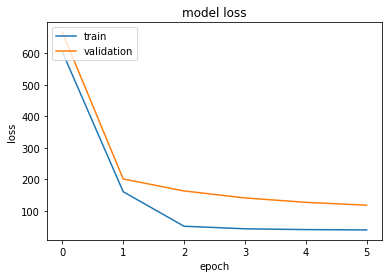

In [12]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
# training rrmse
rrmse_histories = []
rrmse_histories.append(history.history['rrmse'])
rrmse_history = [np.mean([x[i] for x in rrmse_histories]) for i in range(num_epochs)]

In [14]:
# validation rrmse
val_rrmse_histories = []
val_rrmse_histories.append(history.history['val_rrmse'])
val_rrmse_history = [np.mean([x[i] for x in val_rrmse_histories]) for i in range(num_epochs)]

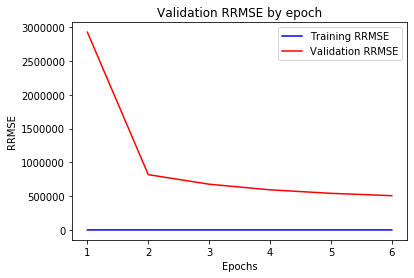

In [15]:
# plotting validation scores
import matplotlib.pyplot as plt
plt.plot(range(1,len(rrmse_history) + 1), rrmse_history, 'b', label='Training RRMSE')
plt.plot(range(1,len(val_rrmse_history) + 1), val_rrmse_history, 'r', label='Validation RRMSE')
plt.title('Validation RRMSE by epoch')
plt.xlabel('Epochs')
plt.ylabel('RRMSE')
plt.legend()
plt.show()

TUNING THE HYPERPARAMETERS IN THE MODEL

**Tuning Batch Size and Epochs**

In [14]:
def create_model():
  model = Sequential()
  model.add(Dense(50, input_dim=65, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.summary()
  model.compile(loss='mae', optimizer = "adam", metrics=[rrmse, 'mse','mae'])
  return model

In [15]:
model = KerasRegressor(build_fn=create_model, verbose=1)
# define the grid search parameters
batch_size = [32, 64, 128]
epochs= [4,8,15]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                3300      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 3,351
Trainable params: 3,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
51000/51000 [==============================] - 2s 38us/step - loss: 714.6274 - rrmse: 4.8858 - mse: 535785.2500 - mae: 714.6274
Epoch 2/15
51000/51000 [==============================] - 2s 33us/step - loss: 415.3288 - rrmse: 2.9445 - mse: 208911.8438 - mae: 415.3283
Epoch 3/15
51000/51000 [==============================] - 2s 34us/step - loss: 108.4928 - rrmse: 0.9138 - mse: 20355.6172 - mae: 108.4928
Epoch 4/15
51000/51000 [==============================] - 2s 38us/step - loss: 66.1984 - rrmse: 0.

In [17]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -85.006368 using {'batch_size': 64, 'epochs': 15}
-98.509103 (29.342050) with: {'batch_size': 32, 'epochs': 4}
-86.830393 (22.700299) with: {'batch_size': 32, 'epochs': 8}
-86.079541 (24.943902) with: {'batch_size': 32, 'epochs': 15}
-140.938757 (50.038997) with: {'batch_size': 64, 'epochs': 4}
-100.983413 (30.916215) with: {'batch_size': 64, 'epochs': 8}
-85.006368 (21.555621) with: {'batch_size': 64, 'epochs': 15}
-510.769197 (123.413539) with: {'batch_size': 128, 'epochs': 4}
-138.906966 (45.024108) with: {'batch_size': 128, 'epochs': 8}
-98.288646 (29.210233) with: {'batch_size': 128, 'epochs': 15}


**Tuning the Training Optimization Algorithm**

In [27]:
def create_model(optimizer="adam"):
  model = Sequential()
  model.add(Dense(50, input_dim=65, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.summary()
  model.compile(loss='mae', optimizer = optimizer, metrics=[rrmse, 'mse','mae'])
  return model


In [28]:
model = KerasRegressor(build_fn=create_model, epochs=15, batch_size=64, verbose=0)
# define the grid search parameters
optimizer = ['RMSprop', 'Nadam', 'Adam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                3300      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 3,351
Trainable params: 3,351
Non-trainable params: 0
_________________________________________________________________


In [29]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -85.911185 using {'optimizer': 'Nadam'}
-86.912375 (22.647786) with: {'optimizer': 'RMSprop'}
-85.911185 (23.892168) with: {'optimizer': 'Nadam'}
-86.557736 (23.753028) with: {'optimizer': 'Adam'}


In [30]:
from keras.optimizers import Nadam

**Tuning the Kernel Initializer**

In [31]:
def create_model(init_mode1='uniform'):
  model = Sequential()
  model.add(Dense(50, input_dim=65, kernel_initializer=init_mode1, activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.summary()
  model.compile(loss='mae', optimizer = 'Nadam', metrics=[rrmse, 'mse','mae'])
  return model

In [32]:
model = KerasRegressor(build_fn=create_model, epochs=15, batch_size=64, verbose=1)
# define the grid search parameters
init_modes = ['uniform', 'lecun_uniform', 'normal']
param_grid = dict(init_mode1=init_modes)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 50)                3300      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 3,351
Trainable params: 3,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
51000/51000 [==============================] - 2s 40us/step - loss: 592.5007 - rrmse: 4.0897 - mse: 396487.0312 - mae: 592.5006
Epoch 2/15
51000/51000 [==============================] - 2s 35us/step - loss: 101.5750 - rrmse: 0.8566 - mse: 19336.5527 - mae: 101.5750
Epoch 3/15
51000/51000 [==============================] - 2s 33us/step - loss: 54.2421 - rrmse: 0.4960 - mse: 5693.7153 - mae: 54.2421
Epoch 4/15
51000/51000 [==============================] - 2s 32us/step - loss: 47.8352 - rrmse: 0.4443

In [33]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -82.139950 using {'init_mode1': 'uniform'}
-82.139950 (19.269129) with: {'init_mode1': 'uniform'}
-86.137367 (25.803580) with: {'init_mode1': 'lecun_uniform'}
-84.580408 (21.948785) with: {'init_mode1': 'normal'}


**Tuning Neuron Activation Function**

In [34]:
def create_model(activation1='relu',activation3='relu'):
  model = Sequential()
  model.add(Dense(50, input_dim=65, kernel_initializer='uniform', activation=activation1))
  model.add(Dense(1, activation=activation3))
  model.summary()
  model.compile(loss='mae', optimizer = 'Nadam', metrics=[rrmse, 'mse','mae'])
  return model

In [35]:
model = KerasRegressor(build_fn=create_model, epochs=15, batch_size=64, verbose=1)
# define the grid search parameters
activation = ['relu', 'tanh', 'linear']
param_grid = dict(activation1=activation,activation3=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 50)                3300      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 3,351
Trainable params: 3,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
51000/51000 [==============================] - 2s 41us/step - loss: 480.0301 - rrmse: 3.3596 - mse: 305704.1875 - mae: 480.0298
Epoch 2/15
51000/51000 [==============================] - 2s 34us/step - loss: 64.5442 - rrmse: 0.5773 - mse: 7864.6626 - mae: 64.5442
Epoch 3/15
51000/51000 [==============================] - 2s 34us/step - loss: 48.3572 - rrmse: 0.4486 - mse: 4653.3198 - mae: 48.3572
Epoch 4/15
51000/51000 [==============================] - 2s 35us/step - loss: 46.1317 - rrmse: 0.4309 - 

In [36]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -80.083720 using {'activation1': 'linear', 'activation3': 'linear'}
-82.606124 (19.744989) with: {'activation1': 'relu', 'activation3': 'relu'}
-766.648558 (136.384564) with: {'activation1': 'relu', 'activation3': 'tanh'}
-83.467604 (20.479870) with: {'activation1': 'relu', 'activation3': 'linear'}
-165.878017 (73.118997) with: {'activation1': 'tanh', 'activation3': 'relu'}
-766.648558 (136.384565) with: {'activation1': 'tanh', 'activation3': 'tanh'}
-165.655816 (73.873975) with: {'activation1': 'tanh', 'activation3': 'linear'}
-83.063460 (20.538096) with: {'activation1': 'linear', 'activation3': 'relu'}
-766.648558 (136.384565) with: {'activation1': 'linear', 'activation3': 'tanh'}
-80.083720 (18.515636) with: {'activation1': 'linear', 'activation3': 'linear'}


**Tuning Dropout Regularization**

In [38]:
def create_model(dropout_rate=0.0):
  model = Sequential()
  model.add(Dense(50, input_dim=65, kernel_initializer='uniform', activation='linear'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, activation='linear'))
  model.summary()
  model.compile(loss='mae', optimizer = 'Nadam', metrics=[rrmse, 'mse','mae'])
  return model

In [39]:
model = KerasRegressor(build_fn=create_model, epochs=15, batch_size=64, verbose=1)
# define the grid search parameters
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 50)                3300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 3,351
Trainable params: 3,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
51000/51000 [==============================] - 2s 49us/step - loss: 479.1058 - rrmse: 3.3604 - mse: 304428.4375 - mae: 479.1058
Epoch 2/15
51000/51000 [==============================] - 2s 39us/step - loss: 64.6044 - rrmse: 0.5777 - mse: 7874.2432 - mae: 64.6044
Epoch 3/15
51000/51000 [==============================] - 2s 37us/step - loss: 48.2876 - rrmse: 0.4480 - mse

In [40]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -81.125097 using {'dropout_rate': 0.0}
-81.125097 (18.842825) with: {'dropout_rate': 0.0}
-82.752335 (21.639799) with: {'dropout_rate': 0.1}
-83.280191 (22.927004) with: {'dropout_rate': 0.2}
-85.020299 (23.551930) with: {'dropout_rate': 0.3}
-86.879940 (25.684575) with: {'dropout_rate': 0.4}
-90.062265 (28.748039) with: {'dropout_rate': 0.5}
-92.275440 (33.538475) with: {'dropout_rate': 0.6}
-95.245091 (39.383429) with: {'dropout_rate': 0.7}
-101.110563 (51.724261) with: {'dropout_rate': 0.8}
-133.484046 (87.273857) with: {'dropout_rate': 0.9}


**Tuning Number of Neurons in the Hidden Layer**

In [41]:
def create_model(neuron1=10):
  model = Sequential()
  model.add(Dense(neuron1, input_dim=65, kernel_initializer='uniform', activation='linear'))
  model.add(Dropout(0.0))
  model.add(Dense(1, activation='linear'))
  model.summary()
  model.compile(loss='mae', optimizer = 'Nadam', metrics=[rrmse, 'mse','mae'])
  return model

In [42]:
model = KerasRegressor(build_fn=create_model, epochs=15, batch_size=64, verbose=1)
# define the grid search parameters
neurons = [10, 20, 32, 50, 64]
param_grid = dict(neuron1=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
51000/51000 [==============================] - 3s 49us/step - loss: 433.2871 - rrmse: 3.0529 - mse: 270797.1875 - mae: 433.2873
Epoch 2/15
51000/51000 [==============================] - 2s 43us/step - loss: 58.4355 - rrmse: 0.5294 - mse: 6560.1426 - mae: 58.4355
Epoch 3/15
51000/51000 [==============================] - 2s 38us/step - loss: 47.1962 - rrmse: 0.4391 - mse

In [43]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -81.111876 using {'neuron1': 64}
-83.744053 (20.384251) with: {'neuron1': 10}
-83.215473 (20.623117) with: {'neuron1': 20}
-83.331469 (19.898617) with: {'neuron1': 32}
-81.284612 (18.943718) with: {'neuron1': 50}
-81.111876 (18.264503) with: {'neuron1': 64}
